Amplitude Estimation Benchmark Program - Cirq
... execution starting at Jun 07, 2024 11:09:20 UTC
************
Executing [2] circuits with num_qubits = 3
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.002, 0.008, 0.004 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 4
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.002, 0.017, 0.007 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 5
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.003, 0.032, 0.014 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 0.999, 0.999

************
Executing [3] circuits with num_qubits = 6
Average Creation, Elapsed, Execution Time for the 6 qubit group = 0.005, 0.061, 0.028 secs
Average Hellinger, Normalized Fidelity for the 6 qubit group = 1.0, 1.0

************
Execu

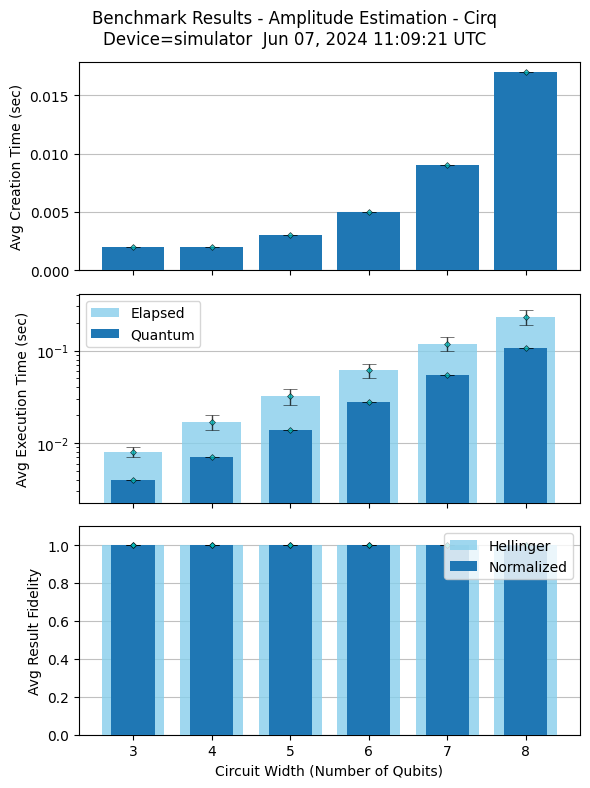

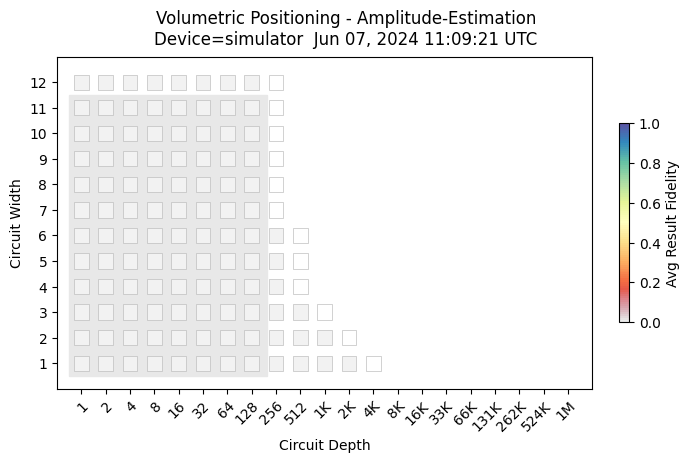

In [1]:
"""
Amplitude Estimation Benchmark Program via Phase Estimation - Cirq
"""

from collections import defaultdict
import copy
import sys
import time

import cirq
import numpy as np

sys.path[1:1] = ["_common", "_common/cirq", "quantum-fourier-transform/cirq"]
sys.path[1:1] = ["../../_common", "../../_common/cirq", "../../quantum-fourier-transform/cirq"]
import cirq_utils as cirq_utils
import execute as ex
import metrics as metrics
from qft_benchmark import inv_qft_gate

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
Q_ = None
cQ_ = None
QC_ = None
QFTI_ = None

############### Circuit Definition

def AmplitudeEstimation(num_state_qubits, num_counting_qubits, a, psi_zero=None, psi_one=None):
    
    qr_state = cirq.GridQubit.rect(1,num_state_qubits+1,0)
    qr_counting = cirq.GridQubit.rect(1,num_counting_qubits,1)
    qc = cirq.Circuit()
    
    num_qubits = num_state_qubits + 1 + num_counting_qubits

    # create the Amplitude Generator circuit
    A_circuit = A_gen(num_state_qubits, a, psi_zero, psi_one)
    A = cirq_utils.to_gate(num_state_qubits+1, A_circuit, name="A")

    # create the Quantum Operator circuit and a controlled version of it
    cQ, Q = Ctrl_Q(num_state_qubits, A_circuit)

    # save small example subcircuits for visualization
    global A_, Q_, cQ_
    if (cQ_ and Q_) == None or num_state_qubits <= 6:
        if num_state_qubits < 9: cQ_ = cQ; Q_ = Q; A_ = A 

    # Prepare state from A, and counting qubits with H transform 
    qc.append(A.on(*qr_state))
    for i in range(num_counting_qubits):
        qc.append(cirq.H.on(qr_counting[i]))
    
    repeat = 1
    for j in reversed(range(num_counting_qubits)):
        for _ in range(repeat):
            qc.append(cQ.on(qr_counting[j], *qr_state))
        repeat *= 2

    # inverse quantum Fourier transform only on counting qubits
    QFT_inv_gate = inv_qft_gate(num_counting_qubits)
    qc.append(QFT_inv_gate.on(*qr_counting))
    
    # measure counting qubits
    qc.append(cirq.measure(*[qr_counting[i_qubit] for i_qubit in range(num_counting_qubits)], key='result'))

    # save smaller circuit example for display
    global QC_,QFTI_
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
    if QFTI_ == None or num_qubits <= 5:
        if num_qubits < 9: QFTI_ = QFT_inv_gate

    # return a handle on the circuit
    return qc

# Construct A operator that takes |0>_{n+1} to sqrt(1-a) |psi_0>|0> + sqrt(a) |psi_1>|1>
def A_gen(num_state_qubits, a, psi_zero=None, psi_one=None):

    if psi_zero==None:
        psi_zero = '0'*num_state_qubits
    if psi_one==None:
        psi_one = '1'*num_state_qubits
        
    theta = 2 * np.arcsin(np.sqrt(a))
    # Let the objective be qubit index n; state is on qubits 0 through n-1
    qr_A = cirq.GridQubit.rect(1,num_state_qubits+1,0)
    qc_A = cirq.Circuit()
    
    # takes state to |0>_{n} (sqrt(1-a) |0> + sqrt(a) |1>)
    qc_A.append(cirq.ry(theta).on(qr_A[num_state_qubits]))

    # takes state to sqrt(1-a) |psi_0>|0> + sqrt(a) |0>_{n}|1>
    qc_A.append(cirq.X(qr_A[num_state_qubits]))
    for i in range(num_state_qubits):
        if psi_zero[i]=='1':
            qc_A.append(cirq.CNOT(qr_A[num_state_qubits],qr_A[i]))
    qc_A.append(cirq.X(qr_A[num_state_qubits]))

    # takes state to sqrt(1-a) |psi_0>|0> + sqrt(a) |psi_1>|1>
    for i in range(num_state_qubits):
        if psi_one[i]=='1':
            qc_A.append(cirq.CNOT(qr_A[num_state_qubits],qr_A[i]))
    
    return qc_A

# Construct the grover-like operator and a controlled version of it
def Ctrl_Q(num_state_qubits, A_circ):

    # index n is the objective qubit, and indexes 0 through n-1 are state qubits
    qr_Q = cirq.GridQubit.rect(1,num_state_qubits+1,0)
    qc_Q = cirq.Circuit()
    
    A_gate = cirq_utils.to_gate(num_state_qubits+1, A_circ, name="A")
    A_gate_inv = cirq.inverse(copy.copy(A_gate))
    
    ### Each cycle in Q applies in order: -S_chi, A_circ_inverse, S_0, A_circ 
    # -S_chi
    qc_Q.append(cirq.X(qr_Q[num_state_qubits]))
    qc_Q.append(cirq.Z(qr_Q[num_state_qubits]))
    qc_Q.append(cirq.X(qr_Q[num_state_qubits]))
        
    # A_circ_inverse
    qc_Q.append(A_gate_inv.on(*qr_Q))
        
    # S_0
    for i in range(num_state_qubits+1):
        qc_Q.append(cirq.X.on(qr_Q[i]))
    qc_Q.append(cirq.H(qr_Q[num_state_qubits]))
    
    qc_Q.append(cirq.X.controlled(num_controls=num_state_qubits).on(*qr_Q))
    
    qc_Q.append(cirq.H(qr_Q[num_state_qubits]))
    for i in range(num_state_qubits+1):
        qc_Q.append(cirq.X.on(qr_Q[i]))
        
    # A_circ
    qc_Q.append(A_gate.on(*qr_Q))
    
    # Create a gate out of the Q operator
    Q_ = cirq_utils.to_gate(num_qubits=num_state_qubits+1, circ=qc_Q, name="Q")
    
    # and also a controlled version of it
    Ctrl_Q_ = cirq.ops.ControlledGate(Q_, num_controls=1)
    
    # and return both
    return Ctrl_Q_, Q_

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_counting_qubits, s_int, num_shots):
    
    measurements = result.measurements['result']
    
    counts_str = defaultdict(lambda: 0)
    for row in measurements:
        counts_str["".join([str(x) for x in reversed(row)])] += 1
        
    counts = bitstring_to_a(counts_str, num_counting_qubits)
    a = a_from_s_int(s_int, num_counting_qubits)
    
    if verbose: print(f"For amplitude {a} measured: {counts}")
    
    # correct distribution is measuring amplitude a 100% of the time
    correct_dist = {a: 1.0}
    correct_dist = {str(key): value for key, value in correct_dist.items()}   #convert the keys of the correct_dist dictionary into strings 

    # generate thermal_dist with amplitudes instead, to be comparable to correct_dist
    bit_thermal_dist = metrics.uniform_dist(num_counting_qubits)
    thermal_dist = bitstring_to_a(bit_thermal_dist, num_counting_qubits)

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist, thermal_dist)
        
    return counts, fidelity

def bitstring_to_a(counts, num_counting_qubits):
    est_counts = {}
    m = num_counting_qubits
    precision = int(num_counting_qubits / (np.log2(10))) + 2
    for key in counts.keys():
        r = counts[key]
        num = int(key,2) / (2**m)
        a_est = round((np.sin(np.pi * num) )** 2, precision)
        if a_est not in est_counts.keys():
            est_counts[a_est] = 0
        est_counts[a_est] += r
    return est_counts

def a_from_s_int(s_int, num_counting_qubits):
    theta = s_int * np.pi / (2**num_counting_qubits)
    precision = int(num_counting_qubits / (np.log2(10))) + 2
    a = round(np.sin(theta)**2, precision)
    return a


################ Benchmark Loop

# Because circuit size grows significantly with num_qubits
# limit the max_qubits here ...
MAX_QUBITS=8

# Execute program with default parameters
def run(min_qubits=3, max_qubits=8, max_circuits=3, num_shots=1000,
        num_state_qubits=1, # default, not exposed to users
        backend_id='simulator', provider_backend=None):

    print("Amplitude Estimation Benchmark Program - Cirq")

    # Clamp the maximum number of qubits
    if max_qubits > MAX_QUBITS:
        print(f"INFO: Amplitude Estimation benchmark is limited to a maximum of {MAX_QUBITS} qubits.")
        max_qubits = MAX_QUBITS
    
    # validate parameters (smallest circuit is 3 qubits)
    num_state_qubits = max(1, num_state_qubits)
    if max_qubits < num_state_qubits + 2:
        print(f"ERROR: AE Benchmark needs at least {num_state_qubits + 2} qubits to run")
        return
    min_qubits = max(max(3, min_qubits), num_state_qubits + 2)
    #print(f"min, max, state = {min_qubits} {max_qubits} {num_state_qubits}")

    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, s_int, num_shots):

        # determine fidelity of result set
        num_counting_qubits = int(num_qubits) - num_state_qubits - 1
        counts, fidelity = analyze_and_print_result(qc, result, num_counting_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):
        
        # as circuit width grows, the number of counting qubits is increased
        num_counting_qubits = num_qubits - num_state_qubits - 1

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_counting_qubits), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(num_counting_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(num_counting_qubits), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()

            a_ = a_from_s_int(s_int, num_counting_qubits)

            qc = AmplitudeEstimation(num_state_qubits, num_counting_qubits, a_)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time() - ts)

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, s_int, num_shots)

        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    # ex.execute_circuits()
    # metrics.aggregate_metrics_for_group(input_size)
    # metrics.report_metrics_for_group(input_size)

    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    qr_state = cirq.GridQubit.rect(1,num_state_qubits+1,0) # we need to create registers to print circuits in cirq
    qr_control = cirq.GridQubit.rect(1,1,1)
    print("\nControlled Quantum Operator 'cQ' ="); print(cirq.Circuit(cQ_.on(qr_control[0], *qr_state)) if cQ_ != None else "  ... too large!")
    print("\nQuantum Operator 'Q' ="); print(cirq.Circuit(cirq.decompose(Q_.on(*qr_state))) if Q_ != None else "  ... too large!")
    print("\nAmplitude Generator 'A' ="); print(cirq.Circuit(cirq.decompose(A_.on(*qr_state))) if A_ != None else "  ... too large!")

    qr_state = cirq.GridQubit.rect(1,QFTI_.num_qubits,0) # we need to create registers to print circuits in cirq
    print("\nInverse QFT Circuit ="); print(cirq.Circuit(cirq.decompose(QFTI_.on(*qr_state))) if QFTI_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Amplitude Estimation - Cirq")


# if main, execute method
if __name__ == '__main__': run()